In [24]:
import numpy as np
import os
import pandas as pd
import random
import torch
import torchaudio

from time import time
from torch import nn
from torch.utils.data import DataLoader

from msc_dataset import MSCDataset

# For data augmentation
import torch.nn.functional as F

In [25]:
# Device setup for Mac M4 Pro (MPS), CUDA (NVIDIA), or CPU fallback
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f"Using device: {DEVICE}")

Using device: mps


In [26]:
# ==================== CONFIGURATION ====================
CFG = {
    'sampling_rate': 16000,
    'frame_length_in_s': 0.04,
    'frame_step_in_s': 0.02,
    'n_mels': 40,
    'f_min': 20,
    'f_max': 4000,
    'seed': 42,
    
    # Training Parameters
    'train_steps': 6000,
    'train_batch_size': 32,
    'learning_rate': 0.0005,
    'epochs': 60,
    
    # Data Augmentation
    'time_shift_ms': 80,
    'noise_level': 0.0005,
    'time_stretch_factor': 0.04,
    
    # Label Smoothing
    'label_smoothing': 0.1,
}

CLASSES = ['stop', 'up']

# Set Deterministic Behaviour
torch.manual_seed(CFG['seed'])
np.random.seed(CFG['seed'])
random.seed(CFG['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [27]:
# ==================== MEL-SPECTROGRAM FEATURE EXTRACTOR ====================
class MelSpectrogramExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=CFG['sampling_rate'],
            n_fft=int(CFG['frame_length_in_s'] * CFG['sampling_rate']),
            hop_length=int(CFG['frame_step_in_s'] * CFG['sampling_rate']),
            n_mels=CFG['n_mels'],
            f_min=CFG['f_min'],
            f_max=CFG['f_max'],
            window_fn=torch.hann_window,
            power=2.0,
            normalized=False,
            center=True,
            pad_mode="reflect"
        )
        
    def forward(self, waveform):
        mel_spec = self.mel_transform(waveform)
        log_mel = torch.log(mel_spec + 1e-9)
        log_mel = (log_mel - log_mel.mean(dim=[1, 2], keepdim=True)) / (log_mel.std(dim=[1, 2], keepdim=True) + 1e-9)
        return log_mel.unsqueeze(1)


In [28]:
# ==================== DATA AUGMENTATION ====================
class AudioAugmentation:
    def __init__(self, config, training=True):
        self.config = config
        self.training = training
        
    def time_shift(self, waveform):
        #if not self.training or random.random() > 0.7:
        #    return waveform
            
        shift_samples = int(random.uniform(-self.config['time_shift_ms'], 
                                          self.config['time_shift_ms']) 
                          * self.config['sampling_rate'] / 1000)
        return torch.roll(waveform, shifts=shift_samples, dims=-1)
    
    def add_noise(self, waveform):
        #if not self.training or random.random() > 0.6:
        #    return waveform
            
        noise = torch.randn_like(waveform) * self.config['noise_level']
        return waveform + noise
    
    def time_stretch(self, waveform):
        #if not self.training or random.random() > 0.7:
        #    return waveform
            
        rate = 1.0 + random.uniform(-self.config['time_stretch_factor'], 
                                    self.config['time_stretch_factor'])
        
        stretched = F.interpolate(
            waveform.unsqueeze(0), 
            size=int(waveform.shape[-1] * rate),
            mode='linear',
            align_corners=False
        ).squeeze(0)
        
        target_len = waveform.shape[-1]
        if stretched.shape[-1] < target_len:
            stretched = F.pad(stretched, (0, target_len - stretched.shape[-1]))
        else:
            stretched = stretched[..., :target_len]
            
        return stretched
    
    def __call__(self, waveform):
        waveform = self.time_shift(waveform)
        waveform = self.add_noise(waveform)
        waveform = self.time_stretch(waveform)
        return waveform


In [29]:
# ==================== CNN MODEL ====================
class KeywordSpotterV2(nn.Module):
    def __init__(self, num_classes=2, dropout=0.2):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=1, bias=False)  # 64->96
        self.bn1 = nn.BatchNorm2d(96)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(dropout * 0.2)
        
        self.conv2a = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1, bias=False)  # 64->96
        self.bn2a = nn.BatchNorm2d(96)
        self.relu2a = nn.ReLU(inplace=True)
        self.conv2b = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1, bias=False)  # 64->96
        self.bn2b = nn.BatchNorm2d(96)
        self.relu2b = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout2d(dropout * 0.2)
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=1, stride=2, bias=False),  # 64->96
            nn.BatchNorm2d(96)
        )
        
        self.conv3 = nn.Conv2d(96, 192, kernel_size=3, stride=2, padding=1, bias=False)  # 64->96, 128->192
        self.bn3 = nn.BatchNorm2d(192)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout2d(dropout * 0.4)
        
        self.conv4a = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1, bias=False)  # 128->192
        self.bn4a = nn.BatchNorm2d(192)
        self.relu4a = nn.ReLU(inplace=True)
        self.conv4b = nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1, bias=False)  # 128->192
        self.bn4b = nn.BatchNorm2d(192)
        self.relu4b = nn.ReLU(inplace=True)
        
        self.conv5 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1, bias=False)  # 128->192, 256->384
        self.bn5 = nn.BatchNorm2d(384)
        self.relu5 = nn.ReLU(inplace=True)
        self.dropout5 = nn.Dropout2d(dropout * 0.8)
        
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(384, 96, kernel_size=1),  # 256->384, 64->96
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 384, kernel_size=1),  # 64->96, 256->384
            nn.Sigmoid()
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout_fc = nn.Dropout(dropout * 0.8)
        self.fc = nn.Linear(384, num_classes, bias=True)  # 256->384
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        
        identity = self.downsample1(x)
        x = self.relu2a(self.bn2a(self.conv2a(x)))
        x = self.bn2b(self.conv2b(x))
        x = self.relu2b(x + identity)
        x = self.dropout2(x)
        
        x = self.dropout3(self.relu3(self.bn3(self.conv3(x))))
        
        identity = x
        x = self.relu4a(self.bn4a(self.conv4a(x)))
        x = self.bn4b(self.conv4b(x))
        x = self.relu4b(x + identity)
        
        x = self.dropout5(self.relu5(self.bn5(self.conv5(x))))
        
        att = self.attention(x)
        x = x * att
        
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc(x)
        x = self.fc(x)
        
        return x

In [30]:
# ==================== TRAINING SETUP ====================
print("=" * 60)
print("UP/STOP KEYWORD SPOTTER")
print("=" * 60)
print(f"Device: {DEVICE}")
print(f"Training: epochs={CFG['epochs']}, batch_size={CFG['train_batch_size']}, lr={CFG['learning_rate']}")
print(f"Augmentation: time_shift=±{CFG['time_shift_ms']}ms, noise={CFG['noise_level']}, stretch=±{CFG['time_stretch_factor']*100}%")
print("=" * 60)

transform = MelSpectrogramExtractor()
train_augmentation = AudioAugmentation(CFG, training=True)
val_augmentation = AudioAugmentation(CFG, training=False)

print("\n📁 Loading datasets...")
train_dataset = MSCDataset(
    root='.',
    classes=CLASSES,
    split='training',
    preprocess=None,
)

val_dataset = MSCDataset(
    root='.',
    classes=CLASSES,
    split='validation',
    preprocess=None,
)

test_dataset = MSCDataset(
    root='.',
    classes=CLASSES,
    split='testing',
    preprocess=None,
)

sampler = torch.utils.data.RandomSampler(
    train_dataset,
    replacement=True,
    num_samples=CFG['train_steps'] * CFG['train_batch_size'],
)
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['train_batch_size'],
    sampler=sampler,
    num_workers=0,
)

val_loader = DataLoader(val_dataset, batch_size=100, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, num_workers=0)

print("\n🏗️  Initializing models...")
feature_extractor = MelSpectrogramExtractor().to(DEVICE)
model = KeywordSpotterV2(num_classes=len(CLASSES), dropout=0.3).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"Estimated size (float32): {total_params * 4 / 1024:.2f} KB")

loss_module = nn.CrossEntropyLoss(label_smoothing=CFG['label_smoothing'])
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CFG['learning_rate'], 
    weight_decay=1e-4,  # RIDOTTO da 2e-4
    betas=(0.9, 0.999)
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,
    T_mult=2,
    eta_min=1e-7
)

best_val_acc = 0
best_val_loss = float('inf')
patience = 20
patience_counter = 0
best_model_state = None
best_feature_extractor_state = None


UP/STOP KEYWORD SPOTTER
Device: mps
Training: epochs=60, batch_size=32, lr=0.0005
Augmentation: time_shift=±80ms, noise=0.0005, stretch=±4.0%

📁 Loading datasets...
Using data folder: ./msc-training
Loaded 1600 samples from ./msc-training for classes ['stop', 'up']
Using data folder: ./msc-validation
Loaded 200 samples from ./msc-validation for classes ['stop', 'up']
Using data folder: ./msc-testing
Loaded 200 samples from ./msc-testing for classes ['stop', 'up']

🏗️  Initializing models...
Model parameters: 1,746,626
Estimated size (float32): 6822.76 KB


In [31]:
# ==================== ASCOLTA EFFETTI DATA AUGMENTATION ====================
import IPython.display as ipd

# Crea augmentation
aug = AudioAugmentation(CFG, training=True)

# Prendi un sample casuale per ogni classe
for class_idx, class_name in enumerate(CLASSES):
    # Trova tutti i sample della classe
    class_samples = [i for i, sample in enumerate(train_dataset) if sample['y'] == class_idx]
    
    # Scegli un sample casuale
    random_idx = random.choice(class_samples)
    sample = train_dataset[random_idx]
    audio_original = sample['x'].squeeze(0)
    
    print(f"\n{'='*60}")
    print(f"CLASSE: {class_name.upper()} (sample {random_idx})")
    print(f"{'='*60}")
    
    # Audio originale
    print(f"\n🔊 Audio Originale:")
    display(ipd.Audio(audio_original.numpy(), rate=CFG['sampling_rate']))
    
    # Audio con augmentation
    audio_augmented = aug(audio_original.unsqueeze(0)).squeeze(0)
    print(f"\n🎛️  Audio con Augmentation (time shift + noise + stretch):")
    display(ipd.Audio(audio_augmented.numpy(), rate=CFG['sampling_rate']))


CLASSE: STOP (sample 1342)

🔊 Audio Originale:



🎛️  Audio con Augmentation (time shift + noise + stretch):



CLASSE: UP (sample 494)

🔊 Audio Originale:



🎛️  Audio con Augmentation (time shift + noise + stretch):


In [32]:
# ==================== TRAINING & EVALUATION FUNCTIONS ====================
def evaluate(model, feature_extractor, loader, device):
    model.eval()
    correct = total = 0
    total_loss = 0
    loss_module = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in loader:
            x = batch['x'].squeeze(1).to(device)
            y = batch['y'].to(device)
            features = feature_extractor(x)
            output = model(features)
            predictions = output.argmax(dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
            total_loss += loss_module(output, y).item()
    
    accuracy = (correct / total) * 100
    avg_loss = total_loss / len(loader)
    return accuracy, avg_loss


def train_epoch(model, feature_extractor, train_loader, optimizer, loss_module, device, 
                steps_per_epoch, current_epoch, augmentation):
    model.train()
    
    start_step = current_epoch * steps_per_epoch
    end_step = start_step + steps_per_epoch
    
    epoch_loss = 0
    step_count = 0
    
    for step, batch in enumerate(train_loader):
        if step < start_step:
            continue
        if step >= end_step:
            break
            
        x = batch['x'].squeeze(1)
        y = batch['y'].to(device)
        
        x_augmented = []
        for i in range(x.shape[0]):
            aug_sample = augmentation(x[i:i+1])
            x_augmented.append(aug_sample)
        x = torch.cat(x_augmented, dim=0).to(device)
        
        with torch.no_grad():
            features = feature_extractor(x)
        
        output = model(features)
        loss = loss_module(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        step_count += 1
        
        if ((step + 1) % 100) == 0 or step == 0:
            print(f'Step={step}; Training Loss={loss.item():.4f}')
    
    avg_epoch_loss = epoch_loss / step_count if step_count > 0 else 0
    return avg_epoch_loss


def test_model(model, feature_extractor, test_loader, device):
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].squeeze(1).to(device)
            y = batch['y'].to(device)
            features = feature_extractor(x)
            output = model(features)
            predictions = output.argmax(dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    accuracy = (correct / total) * 100
    return accuracy


In [33]:
# ==================== TRAINING LOOP ====================
print("\n🚀 Starting training...")

steps_per_epoch = len(train_loader) // CFG['epochs']
current_epoch = 0
train_history = {'epoch': [], 'train_loss': [], 'val_acc': [], 'val_loss': [], 'lr': []}

for epoch in range(CFG['epochs']):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{CFG['epochs']}")
    print(f"{'='*60}")
    
    train_loss = train_epoch(
        model, feature_extractor, train_loader, optimizer, loss_module, 
        DEVICE, steps_per_epoch, epoch, train_augmentation
    )
    
    current_epoch += 1
    val_acc, val_loss = evaluate(model, feature_extractor, val_loader, DEVICE)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'\n📊 Epoch {current_epoch} Summary:')
    print(f'   Train Loss: {train_loss:.4f}')
    print(f'   Val Acc: {val_acc:.2f}%')
    print(f'   Val Loss: {val_loss:.4f}')
    print(f'   Learning Rate: {current_lr:.6f}')
    
    train_history['epoch'].append(current_epoch)
    train_history['train_loss'].append(train_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_loss'].append(val_loss)
    train_history['lr'].append(current_lr)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_feature_extractor_state = feature_extractor.state_dict().copy()
        patience_counter = 0
        print(f'✅ New best model! Val Acc={val_acc:.2f}%')
    else:
        patience_counter += 1
        print(f'⏳ No improvement. Patience: {patience_counter}/{patience}')
    
    if patience_counter >= patience:
        print(f'\n🛑 Early stopping at epoch {current_epoch}')
        break
    
    scheduler.step()

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    feature_extractor.load_state_dict(best_feature_extractor_state)
    print(f'\n✅ Loaded best model with Val Acc={best_val_acc:.2f}%')

print(f"\n{'='*60}")
print(f"Training completed after {current_epoch} epochs")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"{'='*60}")



🚀 Starting training...

EPOCH 1/60
Step=0; Training Loss=0.7073
Step=99; Training Loss=0.4650

📊 Epoch 1 Summary:
   Train Loss: 0.5053
   Val Acc: 82.00%
   Val Loss: 0.4092
   Learning Rate: 0.000500
✅ New best model! Val Acc=82.00%

EPOCH 2/60
Step=99; Training Loss=0.4650

📊 Epoch 1 Summary:
   Train Loss: 0.5053
   Val Acc: 82.00%
   Val Loss: 0.4092
   Learning Rate: 0.000500
✅ New best model! Val Acc=82.00%

EPOCH 2/60
Step=199; Training Loss=0.3064

📊 Epoch 2 Summary:
   Train Loss: 0.3875
   Val Acc: 87.50%
   Val Loss: 0.2740
   Learning Rate: 0.000488
✅ New best model! Val Acc=87.50%

EPOCH 3/60
Step=199; Training Loss=0.3064

📊 Epoch 2 Summary:
   Train Loss: 0.3875
   Val Acc: 87.50%
   Val Loss: 0.2740
   Learning Rate: 0.000488
✅ New best model! Val Acc=87.50%

EPOCH 3/60
Step=299; Training Loss=0.2481

📊 Epoch 3 Summary:
   Train Loss: 0.3402
   Val Acc: 94.50%
   Val Loss: 0.2254
   Learning Rate: 0.000452
✅ New best model! Val Acc=94.50%

EPOCH 4/60
Step=299; Trainin

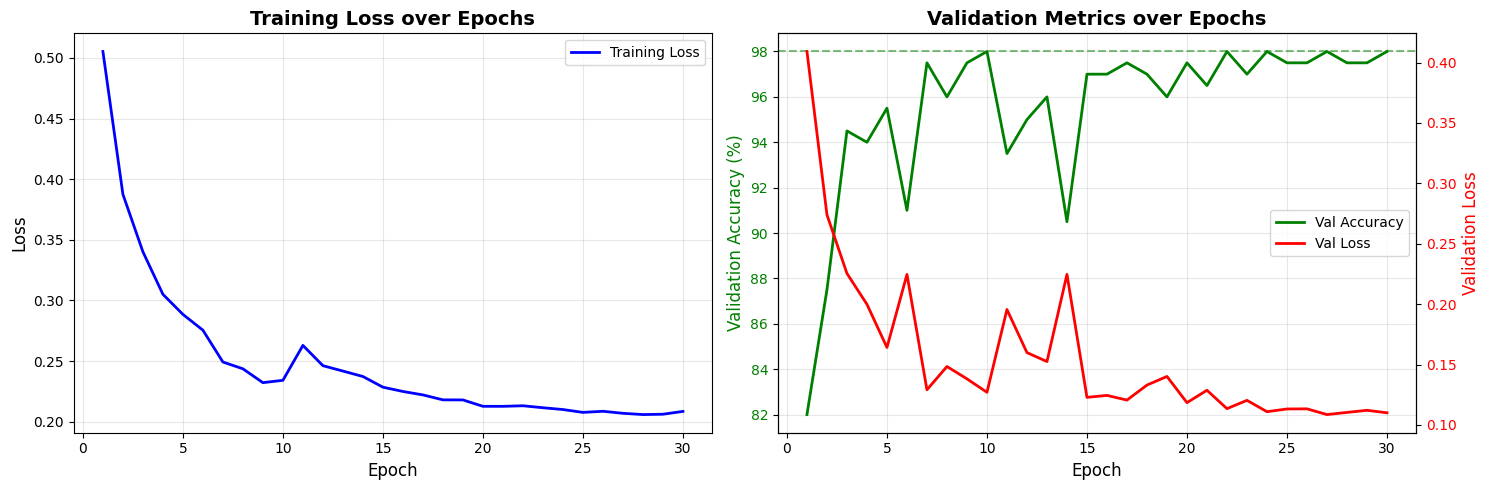


TRAINING DIAGNOSTICS
Epochs trained: 30
Best validation accuracy: 98.00% at epoch 10
Final train loss: 0.2085
Final validation loss: 0.1100
Final validation accuracy: 98.00%

Loss gap (val - train): -0.0985
⚠️  Possibile UNDERFITTING: training loss > validation loss


In [34]:
import matplotlib.pyplot as plt

# Crea una figura con 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
ax1.plot(train_history['epoch'], train_history['train_loss'], 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Plot 2: Validation Accuracy e Loss
ax2_twin = ax2.twinx()

# Validation Accuracy (asse sinistro)
line1 = ax2.plot(train_history['epoch'], train_history['val_acc'], 'g-', linewidth=2, label='Val Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.axhline(y=best_val_acc, color='g', linestyle='--', alpha=0.5, label=f'Best: {best_val_acc:.2f}%')

# Validation Loss (asse destro)
line2 = ax2_twin.plot(train_history['epoch'], train_history['val_loss'], 'r-', linewidth=2, label='Val Loss')
ax2_twin.set_ylabel('Validation Loss', fontsize=12, color='r')
ax2_twin.tick_params(axis='y', labelcolor='r')

ax2.set_title('Validation Metrics over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Combina le legende
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center right', fontsize=10)

plt.tight_layout()
plt.show()

# Print diagnostics
print("\n" + "="*60)
print("TRAINING DIAGNOSTICS")
print("="*60)
print(f"Epochs trained: {len(train_history['epoch'])}")
print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {train_history['epoch'][train_history['val_acc'].index(best_val_acc)]}")
print(f"Final train loss: {train_history['train_loss'][-1]:.4f}")
print(f"Final validation loss: {train_history['val_loss'][-1]:.4f}")
print(f"Final validation accuracy: {train_history['val_acc'][-1]:.2f}%")

# Analisi overfitting/underfitting
final_train_loss = train_history['train_loss'][-1]
final_val_loss = train_history['val_loss'][-1]
gap = final_val_loss - final_train_loss

print(f"\nLoss gap (val - train): {gap:.4f}")
if gap > 0.15:
    print("⚠️  Possibile OVERFITTING: validation loss >> training loss")
elif gap < -0.05:
    print("⚠️  Possibile UNDERFITTING: training loss > validation loss")
elif final_val_loss > 0.3:
    print("⚠️  Possibile UNDERFITTING: loss ancora alta")
else:
    print("✅ Buon bilanciamento tra training e validation")

In [35]:
# ==================== TEST EVALUATION ====================
print("\n📊 Evaluating model on test set...")

model = model.to(DEVICE)
feature_extractor = feature_extractor.to(DEVICE)

test_accuracy = test_model(model, feature_extractor, test_loader, DEVICE)
print(f'\n🎯 Test Accuracy: {test_accuracy:.2f}%')

if test_accuracy > 99.4:
    print("✅ PASSED: Accuracy > 99.4%")
else:
    print("❌ FAILED: Accuracy <= 99.4%")



📊 Evaluating model on test set...

🎯 Test Accuracy: 99.50%
✅ PASSED: Accuracy > 99.4%

🎯 Test Accuracy: 99.50%
✅ PASSED: Accuracy > 99.4%


In [36]:
# ==================== SAVE MODEL ====================
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

timestamp = int(time())
saved_model_dir = './saved_models/'
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

print(f'Model Timestamp: {timestamp}')

model.eval()
feature_extractor.eval()

print("\n🔄 Moving models to CPU for ONNX export...")
model_cpu = model.cpu()
feature_extractor_cpu = feature_extractor.cpu()

print("\n📦 Exporting Feature Extractor to ONNX...")
torch.onnx.export(
    feature_extractor_cpu,
    torch.randn(1, 16000),
    f'{saved_model_dir}/{timestamp}_frontend.onnx',
    input_names=['input'],
    dynamo=True,
    optimize=True,
    report=False,
    external_data=False,
)
print(f"✅ Feature extractor saved: {saved_model_dir}/{timestamp}_frontend.onnx")

print("\n📦 Exporting Model to ONNX...")
sample_waveform = train_dataset[0]['x'].squeeze(0).unsqueeze(0).cpu()
sample_features = feature_extractor_cpu(sample_waveform)
torch.onnx.export(
    model_cpu,
    sample_features,
    f'{saved_model_dir}/{timestamp}_model.onnx',
    input_names=['input'],
    dynamo=True,
    optimize=True,
    report=False,
    external_data=False,
)
print(f"✅ Model saved: {saved_model_dir}/{timestamp}_model.onnx")

fe_size = os.path.getsize(f'{saved_model_dir}/{timestamp}_frontend.onnx') / 1024
model_size = os.path.getsize(f'{saved_model_dir}/{timestamp}_model.onnx') / 1024
total_size = fe_size + model_size

print("\n" + "="*60)
print("SIZE REPORT (ONNX - Float32)")
print("="*60)
print(f"Feature Extractor: {fe_size:.2f} KB")
print(f"Model: {model_size:.2f} KB")
print(f"Total: {total_size:.2f} KB")

if total_size < 300:
    print("✅ PASSED: Total size < 300 KB (before quantization)")
else:
    print("⚠️  WARNING: Size > 300 KB - quantization required!")

print("\n📝 Saving results...")
output_dict = {
    'timestamp': timestamp,
    **CFG,
    'test_accuracy': test_accuracy
}

df = pd.DataFrame([output_dict])
output_path = './keyword_spotter_results.csv'
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path), index=False)
print(f"✅ Results saved to {output_path}")

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)



SAVING MODEL
Model Timestamp: 1764513077

🔄 Moving models to CPU for ONNX export...

📦 Exporting Feature Extractor to ONNX...


W1130 15:31:17.785000 54402 torch/onnx/_internal/exporter/_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `MelSpectrogramExtractor([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MelSpectrogramExtractor([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
✅ Feature extractor saved: ./saved_models//1764513077_frontend.onnx

📦 Exporting Model to ONNX...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
✅ Feature extractor saved: ./saved_models//1764513077_frontend.onnx

📦 Exporting Model to ONNX...


W1130 15:31:18.056000 54402 torch/onnx/_internal/exporter/_registration.py:107] torchvision is not installed. Skipping torchvision::nms


[torch.onnx] Obtain model graph for `KeywordSpotterV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `KeywordSpotterV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Obtain model graph for `KeywordSpotterV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 16 of general pattern rewrite rules.
✅ Model saved: ./saved_models//1764513077_model.onnx

SIZE REPORT (ONNX - Float32)
Feature Extractor: 332.22 KB
Model: 6841.62 KB
Total: 7173.83 KB
⚠️  WARNING: Size > 300 KB - quantization required!

📝 Saving results...
✅ Results saved to ./keyword_spotter_results.csv

TRAINING COMPLETE
Appl